### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [ ]:
# import pickle
# import time
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# def objective(x):
#     return {
#         'loss': x ** 2,
#         'status': STATUS_OK,
#         # -- store other results like this
#         'eval_time': time.time(),
#         'other_stuff': {'type': None, 'value': x},
#         # -- attachments are handled differently
#         'attachments':
#             {'time_module': pickle.dumps(time.time)}
#         }
# trials = Trials()
# best = fmin(objective,
#             space=hp.uniform('x', -10, 10),
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)

# print(best)

In [ ]:
# trials.results

In [ ]:
import pickle
# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex_1hr_1_1_18_4_11_24.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [ ]:
split

31291

In [ ]:
training_index_slice = symbols[1]['EURUSD'].iloc[:split, :].index
validation_index_slice = symbols[1]['EURUSD'].iloc[split:validation_split, :].index
testing_index_slice = symbols[1]['EURUSD'].iloc[validation_split:, :].index

### Create Env

In [ ]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [ ]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [ ]:
sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [ ]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [ ]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    # 'gamma': hp.uniform('gamma', 0.97, 0.99), # Discount factor
    'ent_coef': hp.loguniform('ent_coef', -5, 0), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    'window_size': hp.choice('window_size', [10, 20, 50]) # Window size
}

In [ ]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, window_size_param, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    env_tr.window_size = window_size_param
    print(f'Window size: {window_size_param}, entropy: {entropy}, learning rate: {lr}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []

    tbar = tqdm(range(0, 10))

    for episode in tbar:
        env_val.window_size = window_size_param
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            order_len = len(env_val.render()['orders'])
        except:
            order_len = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'models_4_19_24/window_{window_size_param}_entropy_{round(entropy, 4)}/model_{steps_str}_{episode}.pkl')

        reward_over_validations.append(total_reward)    
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}')
        tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_validations)

    return reward_over_validations, orders_over_validations#, model_dict

### Train + Test Env

In [ ]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    window_size = params['window_size']
    learning_timesteps = 50 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = 0.99 #params['gamma']
    learning_rate = params['learning_rate']#0.0003#

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, models_dict = train_val_model(PPO, policy, env_train, env_validation, seed, step_key, window_size, 
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except:
        print(f'''there was an error with those parameters: Window: {window_size}, timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}     

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [ ]:
# train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '50K', 10, 
#                                                     0.02799659874195376, 0.99, 0.017974439426413188, 50)

--------------------------------------------------------------------------------
Window size: 10, entropy: 0.017974439426413188, learning rate: 0.02799659874195376


Episode: 9, Avg. Reward: -116248.956, # of orders: 1182.600: 100%|██████████| 10/10 [03:42<00:00, 22.23s/it]


([-196259.18615647778,
  -163027.4506019801,
  -60193.115974793414,
  -33481.03474294511,
  -123282.9719137493,
  -128190.88433116282,
  -150003.73539194214,
  10597.696884663514,
  -198958.51830369,
  -119690.36177260947],
 [1030, 1225, 1230, 1261, 1252, 1232, 1236, 1221, 948, 1191])

In [ ]:
# parameters = {
#     'window_size': 10,
#     'learning_timesteps': 25,
#     'ent_coef': 0.021594542314204903,
#     'gamma': 0.9484679718228304,
#     'learning_rate': 0.0661452347963559
# }

In [ ]:
# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [ ]:
trials = Trials()
best = fmin(fn=objective,
             space=space,
             algo=tpe.suggest,
             max_evals=100, # Number of evaluations of the objective function
             trials=trials,
             trials_save_file='hyperopt/trials.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
Window size: 50, entropy: 0.17231225242542986, learning rate: 0.04672331701556057
there was an error with those parameters: Window: 50, timesteps: 50, 

              ent_coef: 0.17231225242542986, gamma: 0.99, learning_rate: 0.04672331701556057
--------------------------------------------------------------------------------
Window size: 50, entropy: 0.4716856260257734, learning rate: 0.011313968897629544
there was an error with those parameters: Window: 50, timesteps: 50, 

              ent_coef: 0.4716856260257734, gamma: 0.99, learning_rate: 0.011313968897629544
--------------------------------------------------------------------------------
Window size: 50, entropy: 0.2090885007699499, learning rate: 0.007334581986252213
there was an error with those parameters: Window: 50, timesteps: 50, 

              ent_coef: 0.2090885007699499, gamma: 0.99, learning_rate: 0.007334581986252213
-------------------

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -118484.038, # of orders: 109.000:   0%|          | 0/10 [00:09<?, ?it/s]
Episode: 0, Avg. Reward: -118484.038, # of orders: 109.000:  10%|#         | 1/10 [00:09<01:28,  9.84s/it]
Episode: 1, Avg. Reward: -128094.921, # of orders: 168.500:  10%|#         | 1/10 [00:29<01:28,  9.84s/it]
Episode: 1, Avg. Reward: -128094.921, # of orders: 168.500:  20%|##        | 2/10 [00:29<02:06, 15.79s/it]
Episode: 2, Avg. Reward: -135409.284, # of orders: 136.000:  20%|##        | 2/10 [00:50<02:06, 15.79s/it]
Episode: 2, Avg. Reward: -135409.284, # of orders: 136.000:  30%|###       | 3/10 [00:50<02:06, 18.08s/it]
Episode: 3, Avg. Reward: -137388.585, # of orders: 115.500:  30%|###       | 3/10 [01:06<02:06, 18.08s/it]
Episode: 3, Avg. Reward: -137388.585, # of orders: 115.500:  40%|####      | 4/10 [01:06<01:44, 17.35s/it]
Episode: 4, Avg. Reward: -143516.636, # of orders: 119.000:  40%|####      | 4/10 [01:24<01:44, 17.35s/it]
Episod

there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.017974439426413188, gamma: 0.99, learning_rate: 0.02799659874195376
--------------------------------------------------------------------------------
Window size: 10, entropy: 0.8353887112646056, learning rate: 0.014998735936743127
there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.8353887112646056, gamma: 0.99, learning_rate: 0.014998735936743127
--------------------------------------------------------------------------------
Window size: 50, entropy: 0.8986214857132158, learning rate: 0.010798216477729288
there was an error with those parameters: Window: 50, timesteps: 50, 

              ent_coef: 0.8986214857132158, gamma: 0.99, learning_rate: 0.010798216477729288
--------------------------------------------------------------------------------
Window size: 50, entropy: 0.013105687068573749, learning rate: 0.10315740609520631
there was an erro

  0%|          | 0/10 [00:00<?, ?it/s]
Episode: 0, Avg. Reward: -96150.767, # of orders: 777.000:   0%|          | 0/10 [00:16<?, ?it/s]
Episode: 0, Avg. Reward: -96150.767, # of orders: 777.000:  10%|#         | 1/10 [00:16<02:32, 16.96s/it]
Episode: 1, Avg. Reward: -101406.803, # of orders: 429.500:  10%|#         | 1/10 [00:34<02:32, 16.96s/it]
Episode: 1, Avg. Reward: -101406.803, # of orders: 429.500:  20%|##        | 2/10 [00:34<02:19, 17.44s/it]
Episode: 2, Avg. Reward: -102987.737, # of orders: 297.667:  20%|##        | 2/10 [00:53<02:19, 17.44s/it]
Episode: 2, Avg. Reward: -102987.737, # of orders: 297.667:  30%|###       | 3/10 [00:53<02:06, 18.11s/it]
Episode: 3, Avg. Reward: -103590.986, # of orders: 225.250:  30%|###       | 3/10 [01:09<02:06, 18.11s/it]
Episode: 3, Avg. Reward: -103590.986, # of orders: 225.250:  40%|####      | 4/10 [01:09<01:42, 17.04s/it]
Episode: 4, Avg. Reward: -103219.962, # of orders: 186.200:  40%|####      | 4/10 [01:25<01:42, 17.04s/it]
Episode:

there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.009319355462529315, gamma: 0.99, learning_rate: 0.05143384821671943
--------------------------------------------------------------------------------
Window size: 10, entropy: 0.9138037496339438, learning rate: 0.025561350886689396
there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.9138037496339438, gamma: 0.99, learning_rate: 0.025561350886689396
--------------------------------------------------------------------------------
Window size: 10, entropy: 0.07282638113881412, learning rate: 0.03806108293997852
there was an error with those parameters: Window: 10, timesteps: 50, 

              ent_coef: 0.07282638113881412, gamma: 0.99, learning_rate: 0.03806108293997852
--------------------------------------------------------------------------------
Window size: 50, entropy: 0.23922181479933305, learning rate: 0.08923830038940554
there was an error

### Plot Results

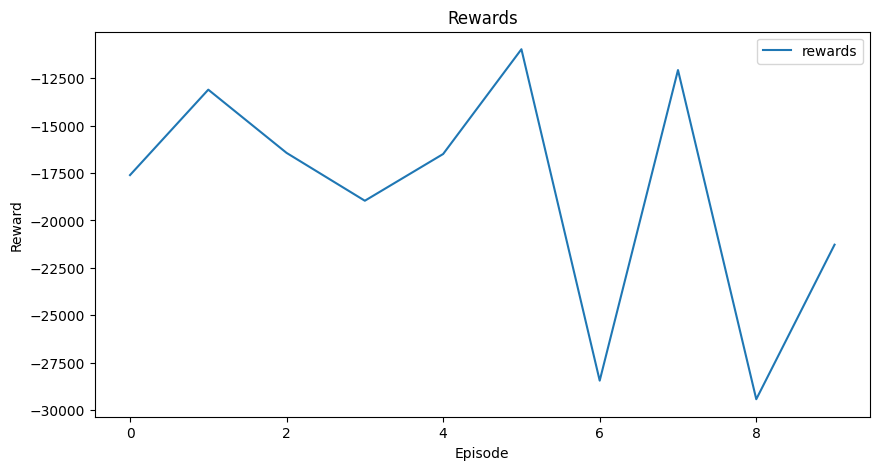

In [ ]:
# # create a dataframe of the rewards
# rewards_df = pd.DataFrame({'rewards': rewards})
# # plot the rewards
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=rewards_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()


In [ ]:
# # import the models from /models folder
# import os
# import glob
# # get the list of models
# model_list = glob.glob('models_4_17_24/*.pkl')
# # separate the strings of each model name on _ and get the last element of the string if the string of the model doesn't include 'initial' or 'updated'
# model_list_episode_nbr = [model.split('_')[-1] for model in model_list if 'initial' not in model and 'updated' not in model]
# model_list_episode_nbr = [int(model_name.split('.')[0]) for model_name in model_list_episode_nbr]
# max_episode = max(model_list_episode_nbr)
# # test the last set of 10 episodes
# init_episode = ((int(max_episode)/10) - 10)*10
# # print(max_episode, init_episode)
# models = []
# # test the last set of 10 episodes from init_episode to max_episode
# for nbr in range(int(init_episode), int(max_episode)+10, 10):
#     # set up the appropriate time_points for each of the models in the list
#     env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index)# make this -nbr not +nbr next time
#     obs_train, info_train = env_train.reset(seed=2024)
#     # find the model name that contains the nbr
#     model_name = [model for model in model_list if str(nbr) in model][0]
#     print(model_name)
#     # load the models into a list
#     models.append(PPO.load(model_name, env=env_train))

In [ ]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = window_size_param,
#     time_points=list(testing_index_slice),
#     hold_threshold=0.1,
#     close_threshold=0.1,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [ ]:
# model_ppo = PPO.load(f'models_4_17_24\model_25K_5.pkl', env=env_train)

# obs_test, info_test = env_testing.reset(seed=2024)
# done_test = False
# while not done_test:
#     action, _states = model_ppo.predict(obs_test)
#     obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#     done_test = terminated_test or truncated_test
#     # total_reward += reward_test
#     if done_test:
#         break
# try:
#     order_len = len(env_testing.render()['orders'])
# except:
#     order_len = 0
# # print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")


In [ ]:
# # if model_dict is still a thing
# for timestep in timesteps_models_dict.keys():
#     models_dict = timesteps_models_dict[timestep]

#     for nbr in range(0, 10):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in range(0, 10):   
#             total_reward = 0
#             done_test = False
#             model_ppo = models_dict[f'model_{nbr}']

#             obs_test, info_test = env_train.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_train.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_train.render()['orders'])
#             except:
#                 order_len = 0
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes)
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

-------- Testing Model 0 with 25K training timesteps --------
-------------------------------------------------------------
Episode: 0, Reward: -261.205, # orders: 2
Episode: 1, Reward: -205.422, # orders: 3


In [ ]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [ ]:
# # if model_dict is still a thing
# for timestep in ['25K']:
#     for nbr in tqdm(range(1, 10)):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         number_of_orders_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in tqdm(range(0, 10)):   
#             total_reward = 0
#             done_test = False
#             model_ppo = PPO.load(f'models_4_17_24\model_{timestep}_{nbr}.pkl', env=env_train)

#             obs_test, info_test = env_testing.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_testing.render()['orders'])
#             except:
#                 order_len = 0
#             number_of_orders_across_episodes.append(order_len)
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes, 'Reward')
#         print_stats(number_of_orders_across_episodes, 'Orders')
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

-------- Testing Model 1 with 25K training timesteps --------
-------------------------------------------------------------
Episode: 0, Reward: -17052.467, # orders: 1128
Episode: 1, Reward: -5659.595, # orders: 1225
Episode: 2, Reward: -14218.372, # orders: 1211
Episode: 3, Reward: -10868.725, # orders: 1192
Episode: 4, Reward: -14950.135, # orders: 1280
Episode: 5, Reward: -12205.789, # orders: 1193
Episode: 6, Reward: -12776.731, # orders: 1203
Episode: 7, Reward: -8311.689, # orders: 1207
Episode: 8, Reward: -3594.591, # orders: 1179
Episode: 9, Reward: -15906.745, # orders: 1221
Min. Reward          : -17052.467
Avg. Reward          : -11554.484
Max. Reward          :  -3594.591
Min. Orders          :   1128.000
Avg. Orders          :   1203.900
Max. Orders          :   1280.000
-------- Testing Model 2 with 25K training timesteps --------
-------------------------------------------------------------
Episode: 0, Reward: -2084.910, # orders: 734
Episode: 1, Reward: -11499.999, # or

In [ ]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [ ]:
# # if the cluster has been restarted
# for nbr, time_points_idx in zip(range(0, 10), range(0, 500, 50)):
#     # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))
#     env_train = MtEnv(
#         original_simulator=sim_train,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         time_points=list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(time_points_idx)), :].index),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     # obs_train, info_train = env_train.reset(seed=2024)
#     total_reward = 0
#     done_test = False
#     model_ppo = PPO.load(f'models\model_{nbr}.pkl', env=env_train)

#     env_testing = MtEnv(
#         original_simulator=sim_testing,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         # time_points=list(testing_index_slice),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     obs_test, info_test = env_testing.reset(seed=2024)
#     while not done_test:
#         action, _states = model_ppo.predict(obs_test)
#         obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#         done_test = terminated_test or truncated_test
#         total_reward += reward_test
#         if done_test:
#             break
#     state = env_testing.render()

#     print(
#         f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
#         f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"

#     )
#     # print(state['orders'].Profit.sum())
#     if len(state['orders']) > 0:
#         print(state['orders'].Profit.sum())

In [ ]:
# max_episode = 120
# for model_nbr in range(0, int(max_episode)+10, 10):
#     print(f'Model: {model_nbr}')
#     over_episodes_rewards = []
#     over_episodes_balance = []
#     obs_training, info_training = env_train.reset(seed=2024)
#     for episode in range(0, 10):
#         obs_test, info_test = env_testing.reset(seed=2024)
        
#         # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))

#         total_reward = 0
#         done_test = False
#         env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(model_nbr)), :].index)
#         obs_training, info_training = env_train.reset(seed=2024)
#         model_ppo = PPO.load(f'models\model_{model_nbr}.pkl', env=env_train)

#         while not done_test:
#             action, _states = model_ppo.predict(obs_test)
#             obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#             done_test = terminated_test or truncated_test

#             total_reward += reward_test
#             if done_test:
#                 break
#         over_episodes_balance.append(info_test['balance'])
#         over_episodes_rewards.append(total_reward)
#         print(f'Episode: {episode}, Reward: {total_reward:.3f}, Balance: {info_test["balance"]:.3f}')
#     print_stats(over_episodes_rewards)
#     print_stats(over_episodes_balance)

Model: 0
Episode: 0, Reward: -3484.361, Balance: 196538.559
Episode: 1, Reward: -3464.076, Balance: 196535.924
Episode: 2, Reward: -3578.827, Balance: 196424.747
Episode: 3, Reward: -4249.509, Balance: 195750.491
Episode: 4, Reward: -5198.528, Balance: 194831.823
Episode: 5, Reward: -6431.152, Balance: 193626.301
Episode: 6, Reward: -5711.899, Balance: 194307.236
Episode: 7, Reward: -1524.592, Balance: 198471.658
Episode: 8, Reward: -1999.785, Balance: 198023.110
Episode: 9, Reward: -1087.783, Balance: 198912.217
Min. Reward          :  -6431.152
Avg. Reward          :  -3673.051
Max. Reward          :  -1087.783
Min. Reward          : 193626.301
Avg. Reward          : 196342.207
Max. Reward          : 198912.217
Model: 10
Episode: 0, Reward: -413.961, Balance: 199586.285
Episode: 1, Reward: -2742.594, Balance: 197257.406
Episode: 2, Reward: -2100.404, Balance: 197899.596
Episode: 3, Reward: -1619.138, Balance: 198380.862
Episode: 4, Reward: -4788.417, Balance: 195211.583
Episode: 5, R

KeyboardInterrupt: 

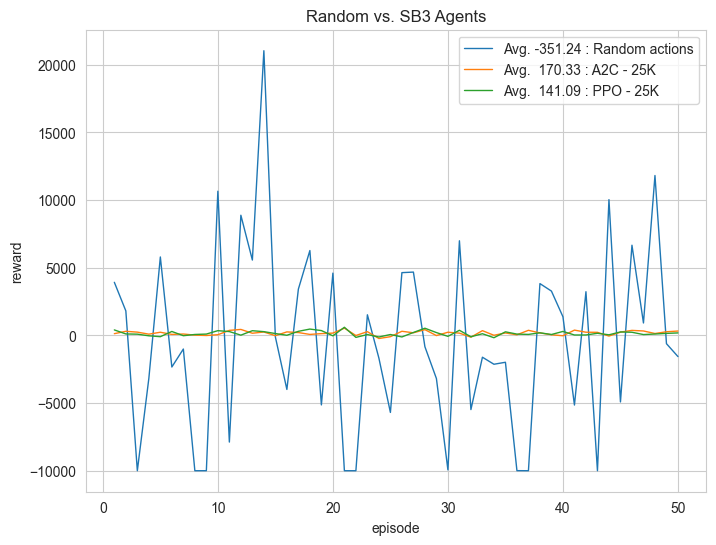

In [ ]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()